# Irreducable representations gradient search
Iščem kandidate za boljše ime...
We have a model 
$$\phi  \mapsto \hat \rho _\phi : G \to \mathbb{F}^{\text{dim} \times \text{dim}}$$
of an unknown irreducable representation $ \rho _\phi : G \to GL_{\text{dim}}\mathbb{F}$.

Using gradient optimisation, we want to change the parameters $\phi \in \mathbb F ^p$ of the model to minimize 
$(1 - ||\chi_{\hat \rho_\phi}||)^2$ and TODO. 

We study, how initial parameters $\phi_0$ effect the convergence/divergence of the optimisation. 
In the future, we might focus on the gradient flow 
$$
\frac{d\phi}{dt} = - \nabla \mathbf{L} (\phi)
$$

### $\rho \colon S_3 \to \mathbb R$
Two distinct real  1dim representations of $S_3$ are $id \colon S_3 \to \mathbb R \setminus \{0\}$ and $\text{sign} \colon S_3 \to \mathbb R\setminus\{0\}$.

TODO: h kateri konvergiramo?

Lets first start with a random model $\hat \rho_\phi \colon S_3 \to \R$, defined with
$\hat \rho_\phi ((1,2)) = p_1$ and $\hat \rho_\phi ((1,3)) = p_2$. 
We will run a gradient descent optimisation on parameters $\phi = (p_1, p_2)$.

In [2]:
from models import GeneratorModel
from groups import demo_S3
from training import training_loop
from loss import triple_loss_function, loss_function_generator
import torch

def extract_info(model):
    irr, rel, uni = loss_function_generator(model)
    return irr.item(), rel.item(), uni.item(), (irr + rel + uni).item()

model = GeneratorModel(demo_S3, 1)
print(f"p_1 = {model.weights[0].item()}")
print(f"p_2 = {model.weights[1].item()}")

opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
losses, infos, converged = training_loop(model, opt, 1000, triple_loss_function, verbose=True, extract_loss_info=extract_info, loading_bar=True, scheduler=scheduler )


Using device: cpu
p_1 = 0.6683186292648315
p_2 = -0.6894093751907349


100%|██████████| 1000/1000 [00:06<00:00, 155.38it/s]

Failed to converge after 1000 steps. Last loss = 0.6725889444351196


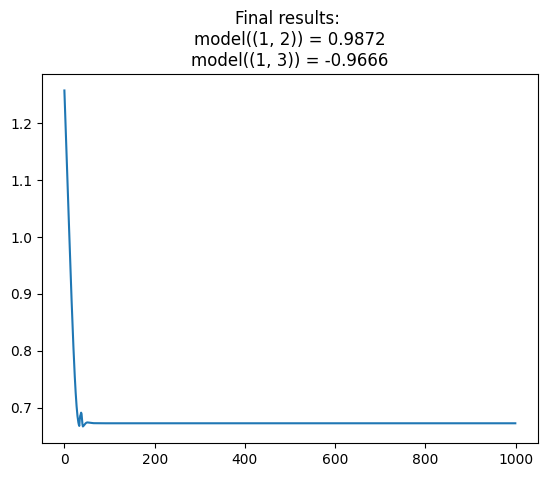

final weights:
model((1, 2)) = tensor([[0.9872]], grad_fn=<SelectBackward0>)
model((1, 3)) = tensor([[-0.9666]], grad_fn=<SelectBackward0>)



In [3]:
import matplotlib.pyplot as plt

plt.plot(losses, label="Loss")
plt.title(
    "Final results: \n"
    + f"model({model.group.generators[0]}) = {round(model.weights[0].item(), 4)}\n"
    + f"model({model.group.generators[1]}) = {round(model.weights[1].item(), 4)}"
)
plt.show()

print("final weights:")
for i in range(2):
    print(f"model({model.group.generators[i]}) = {model.weights[i]}")

print("")

How different parameters affect convergence. We will thest the convergence of $\hat \rho _{\phi = (p_1, p_2)}$, where $p_1, p_2 \in (-2,2)$.

In [4]:
from grid import generate_grid

# simulation info:
# empirical data of simulations below show that opt usually converges on the steps between 150 and 220. We wil set number of opt step to 400.

# TODO PREPARE DEMO DATA OF THIS
# run_name = generate_grid(model, triple_loss_function, -2,2, 50,400)
# print(run_name)

# run: phi from -2 to 2, resolution is 50*50
run_name = '2025-03-21 12:52:50'

In [5]:
from tqdm import tqdm
from grid import param_grid, param_list_to_tensor
import numpy as np
from matplotlib.colors import ListedColormap

plt.rcParams['text.usetex'] = False


def plot_results(
    run_name: str,
    min_param,
    max_param,
    grid_dimensions,
    model,
    eps=1e-3,
):
    """
    Plots convergence speeds based on p1 and p2
    """

    params_shape = model.params_shape
    n_params = n_params = model.weights.numel()

  

    # regenerate params
    params = param_grid(min_param, max_param, grid_dimensions, n_params)
    
    # create 2d arrays, where elements are values with a certain color based on convergence

    to_id = np.zeros((grid_dimensions, grid_dimensions))
    to_sign = np.zeros((grid_dimensions, grid_dimensions))
    both = np.zeros((grid_dimensions, grid_dimensions))

    classes = np.zeros((grid_dimensions, grid_dimensions))

    # load results 
    all_losses = np.load(f"../results/{run_name}_losses.npy")
    all_weights = np.load(f"../results/{run_name}_weights.npy")
    all_conv_results = np.load(f"../results/{run_name}_conv_results.npy")


    
    for index in tqdm(range(grid_dimensions ** n_params), total=grid_dimensions**n_params):
        losses = all_losses[index]
        weights = all_weights[index]
        converged = all_conv_results[index]

        row = (index // grid_dimensions)
        column = (index % grid_dimensions)
        # alternative: if(converged)... Ampak tkole maš lah kel umetno večji epsilon
        if (losses < eps).any():
            # this parameters converge
            if (weights > 1).any():
                # converge to id
                classes[row][column] = 1 
            else:
                classes[row][column] = -1
        else:
            # diverges
            classes[row][column] = 0






    # plot all data
    cmap = ListedColormap(["red", "yellow", "blue"]) 

    im = plt.imshow(classes, interpolation='none', cmap=cmap)
 
    plt.title("Converence of different initial parameters\n" +
                                        "S3 -> R, model((1,2)) = p_1, model((1,3))=p_2")
    #"Convergence of $\text{model} = \hat \rho_{p_1, p_2} \colon S_3 \to \mathbb R$")
    plt.xlabel("p_1")
    plt.ylabel("p_2")

    ax = plt.gca()


    n_ticks = 7
    ax.set_yticks([(i)*1/(n_ticks-1)*grid_dimensions for i in range(n_ticks)], labels=np.linspace(min_param, max_param, num=n_ticks).round(2))
    ax.set_xticks([(i)*1/(n_ticks-1)*grid_dimensions for i in range(n_ticks)], np.linspace(min_param, max_param, num=n_ticks).round(2))
    
    cbar = plt.colorbar(im, ticks=[-1, 0, 1])
    cbar.set_ticklabels(["Sign", "Diverges", "Id"])  

    #plt.savefig(f"../results/imshow/{run_name + "_all_together"}.png")
    plt.show()
    plt.clf()




In [6]:
#run_name='2025-03-21 13:21:52'
# plot_results(run_name, -0.5,0.5,100,model)

### $S_3$ to ortogonal group $\hat \rho \colon S_3 \to O(2)$

(Parts of) the ortogonal group can be parametrimised by $R$ as
$$
a \mapsto \begin{bmatrix}
a & -\sqrt{1 - a^2} \\
\sqrt{1 - a^2} & -a 
\end{bmatrix}.
$$
We again present $S_3$ with two generators and coexter relations as $S_3 = <s_1= (1,2), s_2 = (1,3) \mid s_1^2,s_2^2, s_1 s_2 s_1 s_2 s_1 s_2 >$. 

Our model is given by 
$
\hat \rho_{p, q}((1,2) ) = \begin{bmatrix}
p & -\sqrt{1 - p^2} \\
\sqrt{1 - p^2} & -p
\end{bmatrix}
$
and 
$
\hat \rho_{p, q}((1,3) ) = \begin{bmatrix}
q & -\sqrt{1 - q^2} \\
\sqrt{1 - q^2} & -q 
\end{bmatrix}
$, where $p, q \in \mathbb R$.

The only (up to isomorphism) two-dimensional irreducable representation $\rho$ of S_3 is:
$$
\rho((1,2) ) = \begin{bmatrix}
-\frac{1}{2} & \frac{\sqrt{3}}{2} \\
\frac{\sqrt{3}}{2} & \frac{1}{2} 
\end{bmatrix}, \quad 
\rho((1,3) ) = \begin{bmatrix}
-\frac{1}{2} - i\frac{\sqrt(3)}{2} & -\frac{1}{2} + i\frac{\sqrt(3)}{2} \\
\frac{1}{2} - i\frac{\sqrt(3)}{2} & -\frac{1}{2} - i\frac{\sqrt(3)}{2}
\end{bmatrix},
$$


In [7]:
from demo_S3_O2 import param_to_matrix as param_to_matrix_S3_O2
from demo_S3_O2 import loss_function as loss_function_S3_O2

model = GeneratorModel(demo_S3, dim=2, params_shape=torch.Size([2,1]) ,param_to_matrix=param_to_matrix_S3_O2)


opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
losses, converged = training_loop(model, opt, 10000, loss_function_S3_O2, verbose=True, loading_bar=True, scheduler=scheduler )


100%|██████████| 10000/10000 [02:15<00:00, 73.73it/s]

Failed to converge after 10000 steps. Last loss = 0.6816062927246094


In [8]:
model([0]), model([1])

(tensor([[ 0.9357, -0.3527],
         [ 0.3527, -0.9357]], grad_fn=<ViewBackward0>),
 tensor([[ 0.9399, -0.3416],
         [ 0.3416, -0.9399]], grad_fn=<ViewBackward0>))

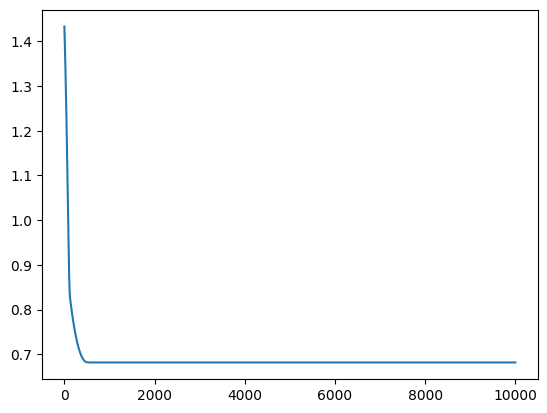

In [9]:
plt.plot(losses, label="Loss")